In [2]:
import numpy as np 
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from numpy import exp
import random

# Task 1. Fill `one_hot_encoded`, `check_accuracy` and `softmax` functions

## 1.1 `One Hot Encoding`
![OHE](https://media.geeksforgeeks.org/wp-content/uploads/20200716042622/vector.png)

## 1.2 `Accuracy` function
Shows share of correct predictions. 


## 1.3 `Softmax` function (see formula)
  
![Softmax](https://raw.githubusercontent.com/l3lush/nn_architecture_misis/fall2022/images/softmax.jpeg)

In [3]:
# utility functions

def one_hot_encoded(y):
    num_of_classes = len(set(y))
    hot_encoded = []

    for elem in y:
      temp = np.zeros(num_of_classes, dtype=int)
      temp[elem] = 1
      hot_encoded.append(temp)

    return hot_encoded
    

def check_accuracy(y_true, y_pred):
    num_of_samples = len(y_true)
    num_of_correct = 0

    for i in range(len(y_pred)):
      if y_pred[i] == y_true[i]:
        num_of_correct += 1

    accuracy = num_of_correct / num_of_samples
    
    return accuracy 


def softmax(X):
  arrays = []
  for obs in X:
    exp = np.exp(obs)
    arrays.append(exp / exp.sum())
  return np.concatenate([arrays])     

# l2 regularization
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0
    for layer in layers:
        if hasattr(layer, 'W'):
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)
    return reg_loss


# l2 regularization grad
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):
            grad[0] += lam * layer.W
    return grads

In [4]:
example = np.array([0, 1, 2, 1, 3])
answer = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1]])
assert np.array_equal(one_hot_encoded(example), answer)

In [5]:
example = np.array([[1.3, 5.1, 2.2, 0.7, 1.1]])
answer = np.array([[0.02, 0.9 , 0.05, 0.01, 0.02]])
assert np.isclose(softmax(example), answer, atol=1e-2).min()

In [6]:
y_true_example = np.array([1, 0, 0, 1, 0])
y_pred_example = np.array([1, 1, 1, 0, 1])
assert check_accuracy(y_true_example, y_pred_example) == 0.2

In [7]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

# Task 2. Realize `ReLU` Class

You need to realize these function:  
  
![ReLU Image](https://pytorch.org/docs/stable/_images/ReLU.png)

In [8]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None
        self.X = None

    def forward(self, X, mode):
        # TODO: realize forward pass of ReLU layer
        # also save X value to self.X
        # YOUR CODE HERE

        A = np.maximum(0.0, X)
        self.X = X

        return A
    
    def backward(self, dout, mode):
        # TODO: realize backward pass of ReLU layer
        # dout - gradient from forward layer,

        Z = self.X
        dZ = np.array(dout)
        dZ[Z <= 0] = 0
        
        self.gradInput = dZ
         
        return self.gradInput, []

In [9]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 12))
grads = relu.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


# Task 3. Realize `Linear` class

![Linear Forward](https://miro.medium.com/max/960/1*0lejoYyyQWjYzEP_BNW2nw.jpeg)
  
Forward pass formula:  
$$ output = XW + B $$ 
In our realization there is **NO** need in transposing $ X $.
  
Backward pass formulas:  
$$ dW = X^{T} \cdot dZ $$
$$ dB = \frac{dZ}{m}$$
$$ d(Input) = dZ \cdot W^{T}$$
where  
$dZ$ - grad from forward layer,  
$m$ - number of rows.

In [10]:
class Linear():
    def __init__(self, in_size, out_size):
        # Xavier init
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size/ 2.)
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        # TODO: realize forward pass for Linear Layer
        # dont forget to save X in self.X
        self.X = X
        output = np.dot(self.X, self.W) + self.b 
        return output
    
    def backward(self, dout, mode):
        m = len(dout)

        dZ = dout

        self.gradW = np.dot(self.X.T, dZ) 
        self.gradB = np.mean(dZ, axis=0) 
        self.gradInput = np.dot(dZ, self.W.T) 

        return self.gradInput, [self.gradW, self.gradB]

In [11]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])
linear = Linear(12, 5)
f = lambda x: linear.forward(x, mode='train').sum(axis=1).sum()
res = f(points)
numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)
inp_grad = np.ones(shape=(10, 5))
grads = linear.backward(inp_grad, mode='train')[0]
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

[[ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.23137639  0.54108689 -1.30535727 -1.39902618]
 [ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.23137639  0.54108689 -1.30535727 -1.39902618]
 [ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.23137639  0.54108689 -1.30535727 -1.39902618]
 [ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.23137639  0.54108689 -1.30535727 -1.39902618]
 [ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.23137639  0.54108689 -1.30535727 -1.39902618]
 [ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.23137639  0.54108689 -1.30535727 -1.39902618]
 [ 0.16538091  0.11877635  1.39488258  0.31198194 -0.8677335   0.61703146
  -0.91834262 -0.20494016 -0.231

# Task 4. Realize `CrossEntropyLoss` class

Cross Entropy Loss forward pass formula:
$$ Loss = \frac{1}{M} \sum_{j=0}^{M}{\sum_{i=0}^{N}{-y_{i}^{j}log(\hat{y}_{i}^{j}) }} $$
$M$ - number of observations in batch (see Task 5)  
$N$ - number of classes  
$y$ - true label of observation  
$\hat{y}$ - predicted label proba (softmax) of observation 
  
Do backward pass formula for yourself (hint: you finally only need decrease all probas by 1 and devide it by m).


In [26]:
class CrossEntropyLoss(object):
    def forward(self, X, y):
        # Hint: save y.shape and softmax probas
        # it is need for backward pass
        self.m = len(y)
        self.p = softmax(X)

        log = -np.log(self.p[range(self.m), y])
        
        return np.sum(log) / self.m

    def backward(self, X, y):
        dx = self.p.copy()
        dx[range(self.m), y] -= 1
        dx /= self.m
        return dx

In [13]:
example = np.array([[1, 2, 3], 
                    [4, 5, 6]])
y_example = np.array([1, 0])
celoss = CrossEntropyLoss()
celoss.forward(example, y_example)
assert round(celoss.forward(example, y_example), 5) == 1.90761

## NN implementation

In [27]:
class NN():
    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self,layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)

        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):

            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)

    def dispGradParam():
        print(self.grads)
    
    def clear_grad_param(self):
        self.grads = []

# Task 5. Realize `minibatch` function

In [28]:
# SGD with momentum
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


# get minibatches
def minibatch(X, y, minibatch_size):
    """
    Cut X and y into minibatches and store it in 
    minibatched list like (X_batch, y_batch)
    Example: [(X_batch1, y_batch1), (X_batch2, y_batch2)]

    Note:
    DO NOT FORGET TO SHUFFLE X AND Y
    """
    #if len(X.shape) > 1:
    #  X = np.concatenate(X)

    minibatches = []
    
    for i in range(minibatch_size):
      batch = (X[i], [y[i]])
      minibatches.append(batch)

    return minibatches

In [29]:
def plot_train_process(train_acc_list, val_acc_list, 
                       mean_train_loss_list, mean_val_loss_list):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Accuracy')
    axes[1].set_title('Loss')
    
    axes[0].plot(train_acc_list, label='train')
    axes[0].plot(val_acc_list, label='val')
    axes[0].legend()
    
    axes[1].plot(mean_train_loss_list, label='train')
    axes[1].plot(mean_val_loss_list, label='val')
    axes[1].legend()
    
    plt.show()


def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True, draw_each_iters=5):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0 

    mean_train_loss_list = []
    mean_val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for n_iter in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        # iterate over mini batches
        for X_mini, y_mini in minibatches:

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates   

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
            
            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)
            
            mean_train_loss_list.append(mean_train_loss)
            mean_val_loss_list.append(mean_val_loss)

            # early stopping with patience = 5 on val loss
            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)  
                    
            if n_iter % draw_each_iters == 0:
                clear_output(True)
                plot_train_process(train_acc_list, val_acc_list, 
                                   mean_train_loss_list, mean_val_loss_list)
    return net

# Task 6. Make a net configuration for training example

In [30]:
def minibatch(X, y, minibatch_size):
    """
    Cut X and y into minibatches and store it in 
    minibatched list like (X_batch, y_batch)
    Example: [(X_batch1, y_batch1), (X_batch2, y_batch2)]

    Note:
    DO NOT FORGET TO SHUFFLE X AND Y
    """
    minibatches = []
    
    shape = X.shape[0]

    for i in range(0, shape, minibatch_size):
      batch = (X[i:i+minibatch_size, ...], y[i:i+minibatch_size, ...])
      minibatches.append(batch) 

    return minibatches

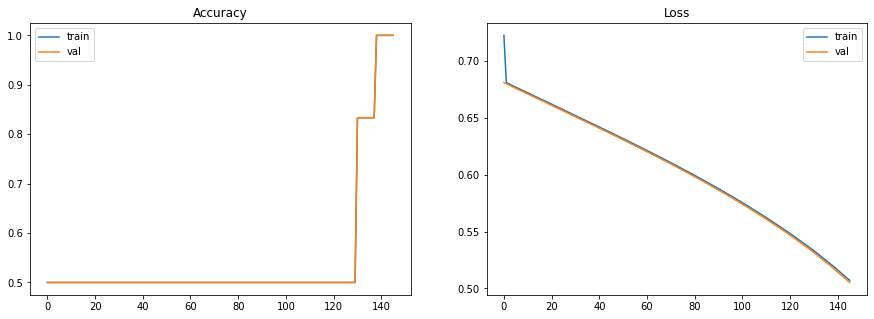

In [49]:
# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
    [2, 1, 2, 1],
    [4, 2, 4, 2]
])

y_train = np.array([0, 1, 0, 1, 0, 1])

X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)

# define neural net
model = NN()

# add some layers (linear and ReLU)
model.add_layer(Linear(4,100))
model.add_layer(ReLU())
model.add_layer(Linear(100,100))
model.add_layer(ReLU())
model.add_layer(Linear(100,2))

model = train(model, X_train , y_train, minibatch_size=6, epoch=150,
           learning_rate=0.1, X_val=X_val, y_val=y_val)

# Task 7. Make a net configuration for Mnist training

In [33]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [34]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [35]:
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

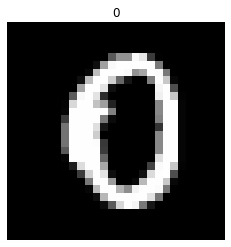

In [36]:
# visualize data

def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

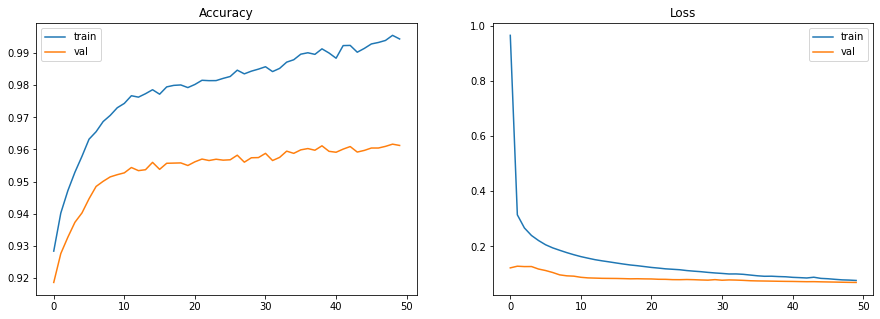

In [40]:
print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers
model.add_layer(Linear(784,100))
model.add_layer(ReLU())
model.add_layer(Linear(100,100))
model.add_layer(ReLU())
model.add_layer(Linear(100,10))

model = train(model, X_train, y_train, minibatch_size=128, epoch=50,
           learning_rate=0.001, X_val=X_val, y_val=y_val, draw_each_iters=1)

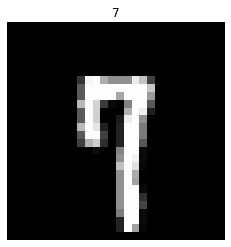

In [41]:
# visualize prediction 

vis_idx = 23
pred = model.predict(X_val[vis_idx])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])

# Extra* Task 8. Try to make you digit classification better by playing with neural net configuration (accuracy > 90%)